In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from typing import Optional, Dict, List
import tkinter as tk
from tkinter import filedialog
import os

def upload_csv_file(what_to_upload:str):
    root = tk.Tk()
    root.withdraw() # Hide the root window as we only want the file dialog.

     # Use filedialog.askopenfilename to open the file explorer.
    # The 'filetypes' parameter is used to filter for only CSV files.
    # The 'title' sets the text for the dialog window.
    # The 'initialdir' is a good practice to set a starting directory,
    # here we use the user's home directory.
    filepath = filedialog.askopenfilename(
        title=what_to_upload,
        initialdir=os.path.expanduser("~"),
        filetypes=(("CSV Files", "*.csv"), ("All Files", "*.*"))
    )
    if filepath:
        print(f"File selected: {filepath}")
        return str(filepath)
    else:
        print("No file selected.")
        return None

def load_and_process_positions(filepath: str) -> pd.DataFrame:
    """
    Loads position data from a CSV and performs initial processing.
    """
    df = pd.read_csv(filepath, encoding='utf-8')
    # Keep only the first 10 columns as a starting point
    df = df[df.columns[0:10]]

    # Explicitly remove the "Today's P/L" column if it exists
    if "Today's P/L" in df.columns:
        df = df.drop(columns=["Today's P/L"])

    return df

def update_current_share_price(shares: pd.DataFrame) -> pd.DataFrame:
    tickers = shares['Symbol'].dropna().unique().tolist()
    if not tickers:
        return shares

    """
    price_data = yf.download(tickers=tickers,
                             period='1d',
                             interval='1h',
                             progress=False)
    """
    price_data = yf.download(tickers=tickers, period='2d',
                             interval='1m',
                             progress=False,
                             prepost=True)

    if price_data.empty:
        print("Warning: Could not download share price data.")
        return shares

    # Extract the most recent price for each ticker
    # Forward-fill to propagate the last valid price, then select the last row.
    # This handles cases where some tickers may not have traded in the last minute.
    latest_prices = price_data['Close'].ffill().iloc[-1].round(decimals=3)
    price_map = latest_prices.to_dict() if isinstance(latest_prices, pd.Series) else {tickers[0]: latest_prices}
    shares['Current price'] = shares['Symbol'].map(price_map)
    return shares

def get_price_from_custom_format(custom_option_string: str) -> Optional[float]:
    """
    Parses a custom option string, finds the contract in the yfinance
    option chain, and returns its last traded price.

    Args:
        custom_option_string: A string in the format "TICKER YYMMDD STRIKE_PRICE(C/P)"
                              e.g., "AMZN 260918 195.00C"

    Returns:
        The last price as a float, or None if not found or an error occurs.
    """
    try:
        # 1. Parse the string using a robust regular expression
        pattern = r'^(?P<ticker>[A-Z]+)\s+(?P<date>\d{6})\s+(?P<strike>[\d.]+)(?P<type>[CP])$'
        match = re.match(pattern, custom_option_string.strip())

        if not match:
            print(f"Warning: Could not parse symbol '{custom_option_string}'")
            return None

        parts = match.groupdict()
        underlying_ticker = parts['ticker']
        exp_date_str = datetime.strptime(parts['date'], '%y%m%d').strftime('%Y-%m-%d')
        strike_price = float(parts['strike'])
        option_type = parts['type']

        # 2. Fetch the option chain for the specific expiration date
        ticker_obj = yf.Ticker(underlying_ticker)
        if option_type == 'C':
            chain = ticker_obj.option_chain(exp_date_str).calls
        else:
            chain = ticker_obj.option_chain(exp_date_str).puts

        # 3. Find the specific contract by its strike price
        contract = chain[chain['strike'] == strike_price]

        # 4. Extract the price if the contract was found
        if not contract.empty:
            return contract['lastPrice'].iloc[0].round(decimals=3)
        else:
            print(f"Warning: Contract for '{custom_option_string}' not found in the option chain.")
            return None

    except Exception as e:
        print(f"Warning: An error occurred for '{custom_option_string}'. Reason: {e}")
        return None

def get_option_prices_from_list(option_list: List[str]) -> Dict[str, Optional[float]]:
    """
    Takes a list of custom option strings and returns a dictionary
    mapping each option to its current price.
    """
    price_results = {}
    for option_string in option_list:
        price_results[option_string] = get_price_from_custom_format(option_string)
    return price_results

def update_option_prices(options: pd.DataFrame) -> pd.DataFrame:
    """
    Fetches current prices for a DataFrame of options.
    """
    contracts = options['Name'].to_list()
    price_dictionary = get_option_prices_from_list(contracts)
    options['Current price'] = options['Name'].map(price_dictionary)
    return options

def update_market_val(portfolio_df: pd.DataFrame) -> None:
    # 1. Create a boolean mask: a Series of True/False for each row.
    is_option = portfolio_df['Symbol'].str.len() > 4

    # 2. Use np.where to create a new Series with the correct quantity for each row.
    effective_quantity = np.where(
        is_option,                      # Condition: For each row, is it an option?
        portfolio_df['Quantity'] * 100, # Value if True: Use Quantity * 100
        portfolio_df['Quantity']        # Value if False: Use just the Quantity
    )

    # 3. Use the new 'effective_quantity' for the final calculation.
    portfolio_df['Market Value'] = (portfolio_df['Current price'].fillna(0) * effective_quantity).round(2)

def update_pl(portfolio_df: pd.DataFrame) -> None:
    is_option = portfolio_df['Symbol'].str.len() > 4
    effective_quantity = np.where(is_option, 
                                  portfolio_df['Quantity'] * 100, 
                                  portfolio_df['Quantity'])
    portfolio_df['P/L'] = ((portfolio_df['Current price'].fillna(0) - portfolio_df['Diluted Cost'].fillna(0)) * effective_quantity).round(2)

def update_pl_ratio(portfolio_df: pd.DataFrame) -> None:
     # Use np.divide to safely handle potential division by zero
    pl_ratio_numeric = np.divide(portfolio_df['Current price'] - portfolio_df['Diluted Cost'], portfolio_df['Diluted Cost']) * 100
    portfolio_df['P/L Ratio'] = pl_ratio_numeric.round(2)
    portfolio_df['P/L Ratio'] = portfolio_df['P/L Ratio'].apply(
        lambda x: f"+{x:.2f}%" if x > 0 else f"{x:.2f}%"
    )
# update % of Portfolio not done yet
def update_portfolio_percentage(portfolio_df: pd.DataFrame) -> None:
    total_market_value = portfolio_df['Market Value'].sum()
    if total_market_value == 0:
        portfolio_df['% of Portfolio'] = 0.0
    else:
        portfolio_df['% of Portfolio'] = (portfolio_df['Market Value'] / total_market_value * 100).round(2)
        portfolio_df['% of Portfolio'] = portfolio_df['% of Portfolio'].apply(
            lambda x: f"{x:.2f}%"
        )

def plot_portfolio_composition(portfolio_df: pd.DataFrame) -> None:
    
    positive_mv = portfolio_df[portfolio_df['Market Value'] > 0]
    
    if positive_mv.empty:
        print("Warning: No positions with positive market value to plot.")
        return

    # Sort by Market Value to make the chart easier to read
    sorted_df = positive_mv.sort_values(by='Market Value', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Market Value', y='Symbol', data=sorted_df, palette='rocket')
    plt.title('Portfolio Composition by Market Value', fontsize=16)
    plt.xlabel('Market Value ($)')
    plt.ylabel('Symbol')
    plt.gca().get_xaxis().set_major_formatter(
        plt.FuncFormatter(lambda x, p: f'${x:,.0f}')
    )
    plt.show()

def plot_pl_by_position(portfolio_df: pd.DataFrame) -> None:
    """
    Plots a bar chart showing the P/L for each position, colored by profit or loss.
    """
    # Sort by P/L for a more organized chart
    sorted_df = portfolio_df.sort_values(by='P/L', ascending=False)
    
    # Create a color palette for the bars
    colors = ["#00d63d" if x > 0 else "#dd2a13" for x in sorted_df['P/L']]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='P/L',
        y='Symbol',
        data=sorted_df,
        palette=colors
    )
    plt.title('Profit/Loss by Position', fontsize=16)
    plt.xlabel('Profit/Loss ($)')
    plt.ylabel('Symbol')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

def plot_asset_class_allocation(portfolio_df: pd.DataFrame) -> None:
    """
    Plots a bar chart showing the total market value in Shares vs. Options.
    """
    # Create a temporary 'Asset Type' column for grouping
    df = portfolio_df.copy()
    df['Asset Type'] = np.where(df['Symbol'].str.len() > 4, 'Options', 'Shares')
    
    # Group by asset type and sum the market value for assets with positive value
    allocation = df[df['Market Value'] > 0].groupby('Asset Type')['Market Value'].sum()
    
    if allocation.empty:
        print("Warning: No assets with positive market value to plot for allocation.")
        return

    plt.figure(figsize=(8, 8))
    colours = ['#4c72b0', '#c44e52', '#55a868', '#8172b3', '#ccb974', '#64b5cd']
    plt.pie(
        allocation,
        labels=allocation.index,
        autopct='%1.1f%%',
        startangle=90,
        explode=[0.05] * len(allocation), # Explode all slices slightly for better visibility
        colors=colours
    )
    plt.title('Asset Class Allocation by Market Value', fontsize=16)
    plt.ylabel('') # Hide the y-label as it's not needed for a pie chart
    plt.show()

In [2]:
filepath = upload_csv_file("Securities Positions CSV File")
df = load_and_process_positions(filepath)
shares = df[df['Symbol'].str.len() <= 4]
options = df[df['Symbol'].str.len() > 4]


shares = update_current_share_price(shares)
options = update_option_prices(options)
display(shares)

File selected: C:/Users/hengl/Downloads/Positions-Margin Account(1706)-20250813-205503.csv


C:\Users\hengl\AppData\Local\Temp\ipykernel_25412\2946446264.py:59: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(tickers=tickers, period='2d',
C:\Users\hengl\AppData\Local\Temp\ipykernel_25412\2946446264.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shares['Current price'] = shares['Symbol'].map(price_map)
C:\Users\hengl\AppData\Local\Temp\ipykernel_25412\2946446264.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  options['Current price

,Symbol,Name,Quantity,Current price,Diluted Cost,Market Value,P/L Ratio,P/L,% of Portfolio
1,ASML,ASML Holding,5.009,756.68,693.965,"3,793.97",+9.15%,317.89,12.61%
2,GOOG,Alphabet-C,15.000,208.50,170.791,"3,127.80",+22.09%,565.93,10.40%
3,SOFI,SoFi Technologies,55.000,26.13,21.285,"1,435.50",+22.62%,264.85,4.77%
5,V,Visa,5.000,348.78,325.369,"1,745.00",+7.26%,118.15,5.80%
6,UNH,UnitedHealth,5.000,303.41,246.400,"1,516.50",+23.09%,284.50,5.04%
7,GRAB,Grab Holdings,200.000,4.98,4.957,996.00,+0.46%,4.68,3.31%
9,MSCI,MSCI Inc,2.000,573.72,532.173,"1,147.44",+7.81%,83.09,3.81%
10,HIMS,Hims & Hers Health,25.000,43.24,48.370,"1,080.00",-10.69%,-129.25,3.59%
11,BN,Brookfield,15.000,64.69,65.963,973.50,-1.61%,-15.95,3.24%
12,ASTS,AST SpaceMobile,15.000,49.90,46.488,748.50,+7.34%,51.18,2.49%


In [3]:
display(options)

,Symbol,Name,Quantity,Current price,Diluted Cost,Market Value,P/L Ratio,P/L,% of Portfolio
0,AMZN260918C195000,AMZN 260918 195.00C,1.0,53.26,50.200,"5,282.50",+5.23%,262.5,17.56%
4,SOFI260918C20000,SOFI 260918 20.00C,1.0,10.20,6.050,"1,010.00",+66.94%,405.0,3.36%
8,GRAB270115C4500,GRAB 270115 4.50C,3.0,1.50,1.483,450.00,+1.15%,5.0,1.50%
15,NU260918C15000,NU 260918 15.00C,2.0,2.30,1.715,478.00,+39.36%,135.0,1.59%


In [4]:
portfolio_df = pd.concat([shares, options], ignore_index=True)

update_market_val(portfolio_df)
update_pl(portfolio_df)
update_pl_ratio(portfolio_df)
update_portfolio_percentage(portfolio_df)
portfolio_df = portfolio_df.sort_values(by='Market Value', ascending=False, ignore_index=True)

print("\n--- Detailed Positions ---")
display(portfolio_df)


--- Detailed Positions ---


,Symbol,Name,Quantity,Current price,Diluted Cost,Market Value,P/L Ratio,P/L,% of Portfolio
0,AMZN260918C195000,AMZN 260918 195.00C,1.000,53.26,50.200,5326.00,+6.10%,306.00,21.10%
1,ASML,ASML Holding,5.009,756.68,693.965,3790.21,+9.04%,314.14,15.01%
2,GOOG,Alphabet-C,15.000,208.50,170.791,3127.50,+22.08%,565.64,12.39%
3,V,Visa,5.000,348.78,325.369,1743.90,+7.20%,117.05,6.91%
4,UNH,UnitedHealth,5.000,303.41,246.400,1517.05,+23.14%,285.05,6.01%
5,SOFI,SoFi Technologies,55.000,26.13,21.285,1437.15,+22.76%,266.47,5.69%
6,MSCI,MSCI Inc,2.000,573.72,532.173,1147.44,+7.81%,83.09,4.55%
7,HIMS,Hims & Hers Health,25.000,43.24,48.370,1081.00,-10.61%,-128.25,4.28%
8,SOFI260918C20000,SOFI 260918 20.00C,1.000,10.20,6.050,1020.00,+68.60%,415.00,4.04%
9,GRAB,Grab Holdings,200.000,4.98,4.957,996.00,+0.46%,4.60,3.95%


C:\Users\hengl\AppData\Local\Temp\ipykernel_25412\2946446264.py:194: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Market Value', y='Symbol', data=sorted_df, palette='rocket')



Generating visualizations...


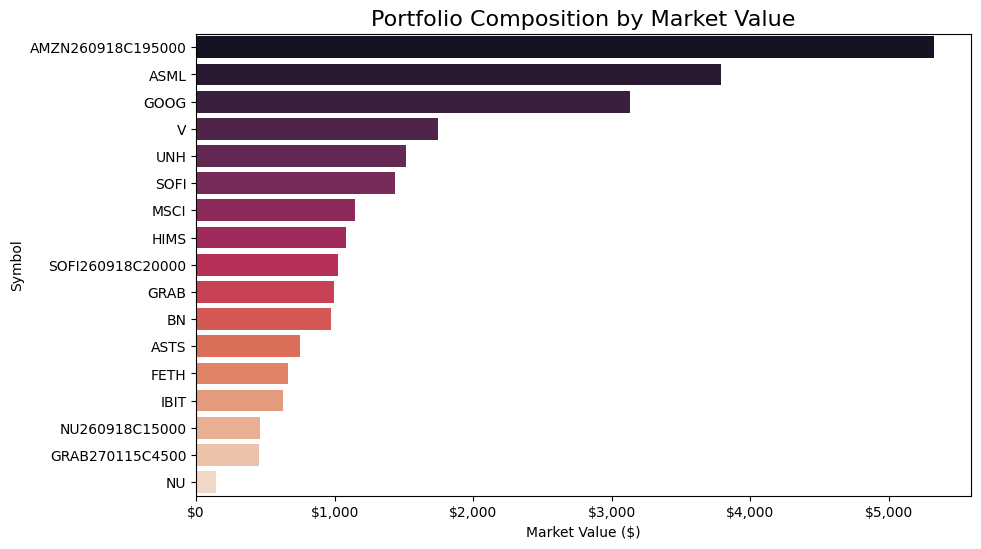

C:\Users\hengl\AppData\Local\Temp\ipykernel_25412\2946446264.py:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


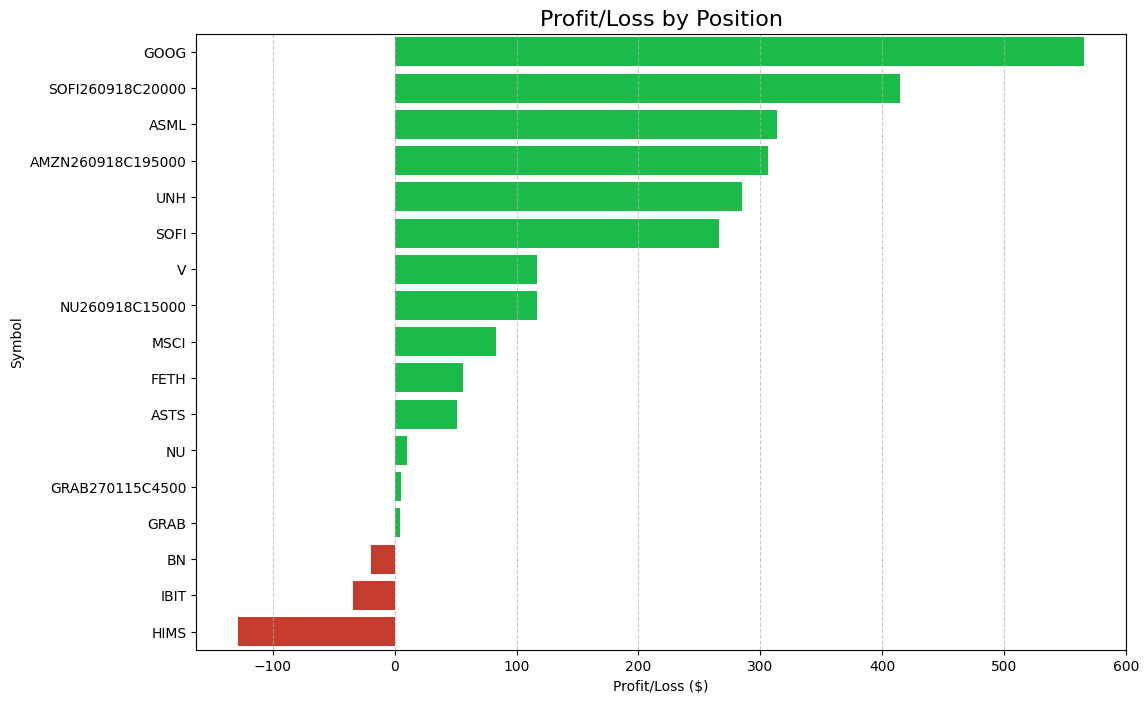

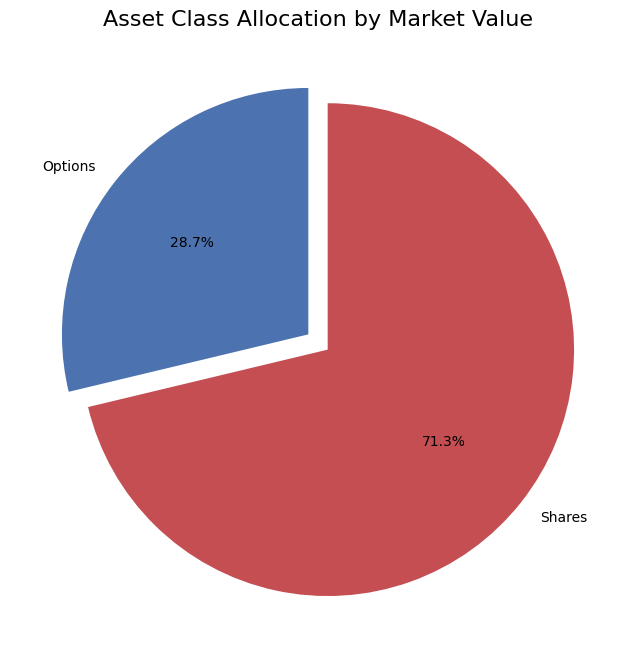

In [5]:
# --- Visualization ---
print("\nGenerating visualizations...")
plot_portfolio_composition(portfolio_df)
plot_pl_by_position(portfolio_df)
plot_asset_class_allocation(portfolio_df)

In [6]:
cash_filepath = upload_csv_file("Cash position CSV File")
cash = pd.read_csv(cash_filepath, encoding='utf-8')
display(cash)

File selected: C:/Users/hengl/Downloads/Fund Positions-Margin Account(1706)-20250813-230346.csv


,ISIN,Name,Position Amount,Units,New Gains,Position P/L,Position P/L%,Currency
0,SGXZ96797238,CSOP USD Money Market Fund,223.85,194.79,0.26,15.85,--,USD
